# Modelisation of a radiative condenser using water as a refrigerant

In the current context, energitical economies as well as limitation over high GWP refrigerants are in the the priorities of the refrigeration sector. This project has the aim to answer two problematics: canyon urban canyon and refrigeration choice. Indeed, water as a refrigerant in terms of environemental impacts is one of the best possible. Added to that, the efficiency of a condenser is linked to the ambient temperature which is increases by those same device in urban canyon up to 2°C. This is why the main objectif of the modelisation is to see how can PDRC technologies (avoid heat accumulation by sending it into space) be implented to a condenser.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize

import CoolProp.CoolProp as CP

Not understandable pics in the modelisation where seen. After investigations, it happens that the CoolProp conductivity for this range of pressure is not well set and admit a strange pic in the varation as one can see below. The corrective function will be used in the following.

The correction is made from the CoolProp density. Indeed, the conductivity and the density have the same evolution shape and with adjustment we can obtain the correct shape of the conductivity.

**Cool Prop corrections**

Superheating: x =-1.0 
SubCooling: x = -1.0


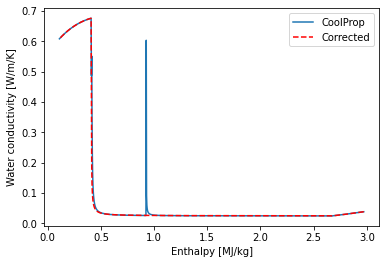

In [9]:
Ptest = 93320
Hintest,Houttest = CP.PropsSI('H','P',Ptest,'Q',1,'water'), CP.PropsSI('H','P',Ptest,'Q',0,'water')

#Change the function Lambda of CoolProp by this one approximate at the same shape as rho
def Lambda(P,H):
    if CP.PropsSI('H','P',P,'Q',0,'water')< H and H<CP.PropsSI('H','P',P,'Q',1,'water'):
        Min = (1-CP.PropsSI('D','P',P,'H',H,'water'))*CP.PropsSI('L','P',P,'Q',1,'water')
        Max = CP.PropsSI('D','P',P,'H',H,'water')*CP.PropsSI('L','P',P,'Q',0,'water')
        return ((Max+Min)/CP.PropsSI('D','P',P,'Q',0,'water'))+CP.PropsSI('L','P',P,'Q',1,'water')
    #In case of sub cooling or super heating, density does not evolve as the conductivity
    return CP.PropsSI('L','P',P,'H',H,'water')

#Plot
RHO, LAMBDA, LAMB2 = [],[],[]
HT = np.linspace(Hintest+3e5,Houttest-3e5,1000) #Plot with super heating and subcooling
RHO = [CP.PropsSI('D','P',Ptest,'H',h,'water') for h in HT]
LAMBDA, LAMB2 = [CP.PropsSI('L','P',Ptest,'H',h,'water') for h in HT],[Lambda(Ptest,h) for h in HT]

plt.plot(HT*1e-6,LAMBDA ,label = 'CoolProp')
plt.plot(HT*1e-6,LAMB2,'--',color = 'red',label = 'Corrected')
plt.xlabel('Enthalpy [MJ/kg]')
plt.ylabel('Water conductivity [W/m/K]')
plt.legend();

#Correction for the CoolProp of the title
Tintest = 70+273.15 #K
Pintest = CP.PropsSI('P','T',Tintest,'Q',1,'water')
Td = +10
Hintest = CP.PropsSI('H','P',Pintest,'T',Tintest+Td,'water') # +10 superheating: pur gas
Hintest2 = CP.PropsSI('H','P',Pintest,'T',Tintest-Td,'water') #-10 subcooling: pur liquid
print(f"""Superheating: x ={CP.PropsSI('Q','P',Pintest,'H',Hintest,'water')} 
SubCooling: x = {CP.PropsSI('Q','P',Pintest,'H',Hintest2,'water')}""") #= -1 for pur water AND pur gas: no distinction are made

def Title(P,H): #make the distinction between pur gas and pur liquid
    if H>=CP.PropsSI('H','P',P,'Q',1,'water'):
        return 1
    if H<=CP.PropsSI('H','P',P,'Q',0,'water'):
        return 0
    return CP.PropsSI('Q','H',H,'P',P,'water')

## PDRC study

**Expressions of the heat transfer done by a PDRC material**

Not yet found atmospheric data within 4-30 microns so we will stay with a PDRC in the 8-13 window for the tests
$\dot{Q}_{net}(T_w) = \pi \Bigg( \int_{8\mu m}^{13} \Big( I_{BB}(\lambda,T_w)\epsilon - I_{BB}(\lambda,T_{amb})\epsilon_{atm}(\lambda) \Big)d\lambda - \int_{0.3 \mu m}^{2.5\mu m}  \big( 1-R\big) I_{solar}(\lambda) d\lambda \Bigg) - h_{air}(T_{amb}-T_w)$

with $I_{BB} (T,\lambda)=\frac{2hc^2}{\lambda^5 (exp⁡(\frac{hc}{k_B \lambda T})-1)}$

Not yet found atmospheric data within 4-30 microns so we will stay with a PDRC in the 8-13 window for the tests

$Q_{rad} = \pi \int_{8\mu m}^{13} I_{BB}(\lambda,T_w)\epsilon d\lambda$
                                             
$Q_{atm} = \pi \int_{8\mu m}^{13} I_{BB}(\lambda,T_{amb})\epsilon_{atm}(\lambda)\epsilon d\lambda $
                    
$Q_{sun} = \pi \int_{0.3 \mu m}^{2.5\mu m}  \big( 1-R\big) I_{solar}(\lambda) d\lambda $

$ Q_{nonrad} = h_{air}(T_{amb}-T_w) $

$\dot{Q}_{net}(T_w) = Q_{rad} - Q_{atm} - Q_{sun} - Q_{nonrad} = \pi \Bigg( \int_{8\mu m}^{13} \Big( I_{BB}(\lambda,T_w)\epsilon - I_{BB}(\lambda,T_{amb})\epsilon_{atm}(\lambda) \Big)d\lambda - \int_{0.3 \mu m}^{2.5\mu m}  \big( 1-R\big) I_{solar}(\lambda) d\lambda \Bigg) - h_{air}(T_{amb}-T_w)$


with $I_{BB} (T,\lambda)=\frac{2hc^2}{\lambda^5 (exp⁡(\frac{hc}{k_B \lambda T})-1)}$

Qnonrad = -0.0 W/m2
Qrad0 = 225.0465927753187 W/m2
Qsun = 62.36529063081202 W/m2
Qatm = 26.176187662932946 W/m2
Equivalent Tciel = -125.82572408941385°C
Qnet = 145.75529154447133 W/m2 for Tc = 50°C


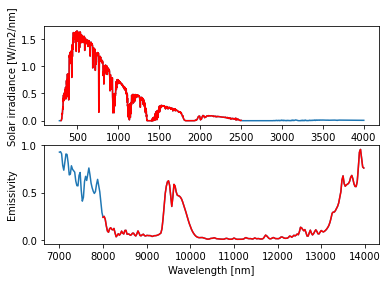

In [10]:
#Constant
hPlank = 6.62e-34 #J.s
c = 3e8 #m/s
kb = 1.38e-23 #J/K
sig = 5.67e-8 #W/m2/K4
Tamb = 30+273.15 #K
em = 0.98 #emittance
R = 0.98 #reflectance

#Importation of atmospheric data
df = pd.read_excel(r"AtmosphericData.xlsx")
df8_13 = df[df['WaveL']>=8][df[df['WaveL']>=8]['WaveL']<=14] #select the values between 8 and 13 microns
waveL = np.array([lamb*1e3 for lamb in df8_13['WaveL']]) #nm
EmAtm = np.array([em for em in df8_13['Em']])

#Importation of solar data
df2 = pd.read_excel(r'SolarData.xlsx')
df2.head()
df300_2500 = df2[df2['WaveL']>=300][df2[df2['WaveL']>=300]['WaveL']<=2500] #select the values between 0.3 and 2.5 microns
waveLsun = np.array([lamb for lamb in df300_2500['WaveL']]) #nm
Isun = np.array([I for I in df300_2500['GlobalTilt']]) #W/m2/nm

#Plot
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(df2['WaveL'],df2['GlobalTilt'])
ax1.plot(waveLsun,Isun,'red')
ax1.set_ylabel('Solar irradiance [W/m2/nm]')

ax2.plot(df['WaveL']*1e3,df['Em'])
ax2.plot(waveL,EmAtm,'red')
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Emissivity');

#Calculation
def Ibb(T,lamb,h=hPlank,c=c,kb=kb): #W/m2/nm
    # lamb is in m
    return (2*hPlank*c**2/(lamb**5*(np.exp(hPlank*c/(kb*lamb*T))-1)))*1e-9

#Separation of the different flux of the PDRC
#Convectif
hair = 0 #W/m2/K (convective flux)
def Q_air(Tc,hair=hair,Tamb=Tamb):
    return hair*(Tamb-Tc)
Qair = Q_air(320.15);print(f'Qnonrad = {Qair} W/m2')

#Radiatif
def Q_rad(Tc):
    Rad = Ibb(Tc,waveL*1e-9)*em
    return np.pi*integrate.simpson(Rad,waveL)
#Q_rad = lambda Tc: sig*em*Tc**4
Qrad0 = Q_rad(320.15);print(f'Qrad0 = {Qrad0} W/m2')

#Solar
Sun = (1-R)*Isun
Qsun = np.pi*integrate.simpson(Sun,waveLsun);print(f'Qsun = {Qsun} W/m2')

#Atm
Atm = Ibb(Tamb,waveL*1e-9)*EmAtm*em
Qatm = np.pi*integrate.simpson(Atm,waveL); print(f'Qatm = {Qatm} W/m2')
# Tsky = -100+273.15
# Qatm = em*sig*Tsky**4; print(f'Qatm = {Qatm} W/m2')

#Equivalent Tciel
sig = 5.67e-8
Tciel = (Qatm/sig/em)**(1/4);print(f'Equivalent Tciel = {Tciel-273.15}°C')

Q_net = lambda Tc,hair=hair,Tamb=Tamb:Q_rad(Tc)-Qsun-Qatm-Q_air(Tc,hair,Tamb)

print(f'Qnet = {Q_net(323.15)} W/m2 for Tc = {50}°C')

# def Q_PDRC(Tc,hair = hair,Tamb=Tamb): #Tc in K
#     Rad = Ibb(Tc,waveL*1e-9)*em-Ibb(Tamb,waveL*1e-9)*EmAtm*em #W/m2/nm (radiation/atm spectrum within 8-13 microns)
#     Intrad = integrate.simpson(Rad,waveL)
#     Sun = (1-R)*Isun #W/m2/nm (solar spectrum within 0.3 and 2.5 microns)
#     Intsun = integrate.simpson(Sun,waveLsun)
#     Nonrad = hair*(Tamb-Tc)
#     return np.pi*(Intrad-Intsun) - Nonrad #W/m2

### Piecewise linearisation of the radiative term

In order to simplify the resolution of the system, a linearisation approach is considered for the $Q_{rad}$ component to allow different exchange surfaces.

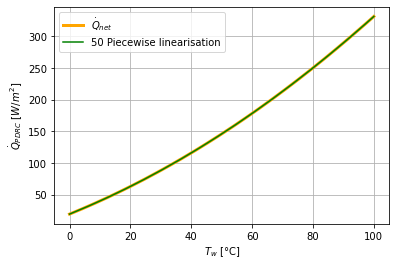

The maximum gap is 0.06864589847407387 W/m^2


In [18]:
#Linerarisation
N = 50
prec = 5000
def MultiLin(n=N,Tmin=0,Tmax=100,prec=prec):
    Tc = np.linspace(Tmin+273.15,Tmax+273.15,prec-N+1) # the final lenght is of size prec
    QP = [Q_rad(T) for T in Tc]
    Cut = np.arange(0,len(Tc)+1,len(Tc)//n)
    if len(Tc)%n!=0:
        Cut[-1]+= len(Tc)%n
    Coeff = [np.polyfit(Tc[Cut[0]:Cut[1]],QP[Cut[0]:Cut[1]],1)]
    ylin = [Coeff[0][0]*Tc[Cut[0]:Cut[1]]+Coeff[0][1]]
    for i in range(1,n):
        Coeff.append(np.polyfit(Tc[Cut[i]:Cut[i+1]],QP[Cut[i]:Cut[i+1]],1))
        Coeff[i][1] = ylin[i-1][-1]-Coeff[i][0]*Tc[Cut[i]-1] # continuity
        ylin.append(Coeff[i][0]*Tc[Cut[i]-1:Cut[i+1]]+Coeff[i][1]) # "Cut[i]-1" for the continuity
    return Coeff,Cut, np.concatenate(ylin)

Coeff,Cut, Y = MultiLin()

def TwcMultiLin(Q, Coeff=Coeff, QY=Y,Cut = Cut,n=N): #return Tw for a given Q
    for idx in range(n):
        y = QY[Cut[idx]:Cut[idx+1]+idx] #Cut[idx+1]+idx] for the continuity
        if Q>=np.min(y) and Q<=np.max(y):
            return (Q-Coeff[idx][1])/Coeff[idx][0]

#Plot
Tc = np.linspace(0,100,prec)
QP = np.array([Q_rad(T+273.15) for T in Tc])
plt.plot(Tc,QP-Q_air(Tc+273.15)-Qatm-Qsun,'orange',label = '$\dot{Q}_{net}$',linewidth = 3)
plt.plot(Tc,Y-Q_air(Tc+273.15)-Qatm-Qsun, 'green',label = f'{N} Piecewise linearisation')
#plt.plot(Tc,QP*2*dx*(w+et)-Qatm*w*dx-Qsun*w*dx,'orange',label = '$Q [W]$',linewidth = 3)
#plt.plot(Tc,Y*2*dx*(w+et)-Qatm*w*dx-Qsun*w*dx, 'green',label = f'{N} Piecewise linearisation')
plt.xlabel('$T_w$ [°C]')
plt.ylabel('$\dot{Q}_{PDRC} \ [W/m^2]$')
plt.legend()
plt.grid()
#plt.savefig("MultiLin.png",dpi=200)
plt.show()

#Precision
print(f'The maximum gap is {np.max(abs(QP-Y))} W/m^2')

## Modelisation of the system

###  Model with fins (en cours)

In this model, we consider the following geometry: a one channel tube discretized in mesh where the gaz goes one way and liquid can accumulate in the tube (or not if the inclinaison is enough: this will be taken into in the angle and the void rate).

Added to that fins are implented to this model. This will increases the flux for wall temperature higher than the ambient temperature, this model need to be seen with the one without fins.

**Initialisation**

In [19]:
#Fluid parameters
Ntube = 20
mwater = 0.43/Ntube #kg/s
Tin = 65+273.15 #K
Pin = CP.PropsSI('P','T',Tin,'Q',1,'water');print(f'P_in = {Pin} Pa') #Pa
Hin= CP.PropsSI('H','P',Pin,'Q',1,'water')
Tamb = 30+273.15 #K
#Surchauffe
Tsurch = 10
Tin +=Tsurch
Hin= CP.PropsSI('H','P',Pin,'T',Tin,'water')
hair = 8 #W/m2/K
#Geometry
Lmax = 13 #250m (length of the tube)
ni = int(5e3) #number of mesh
dx = Lmax/ni;print(f'dx ={dx*1e3} mm') #m (elementary length)
et = 25.4e-3 #120e-3m (tube height)
w = 190e-3; print(f'Total width = {w*Ntube}m') #m #tube width

e = 1.1e-3 #m (tube thickness)
theta = np.pi/60; print(f'theta ={theta*360/2/np.pi}°') #np.pi/20 rad (angle d'inclinaison)
condt = 239 #W/m/K (thermal conductivity of the material: aluminium)

G = mwater/(w*et) # kg/m2/s (water speed*density)
Dh = 4*w*et/(2*(w+et)); #m (hydraulic diameter)
K=0.4
Rein = G*Dh/CP.PropsSI('V','T',Tin,'Q',1,'water');print(f'entry Re = {Rein}') #Rel = min(Rel,Reg)
print(f'L/Dh = {Lmax/Dh}')
print(" ")

#Fins parameters ( if Tw>T)

Fp = 2.3e-3 #length between two fins
Ft = 0.25e-3 #thicnkess of a fin
Fs = Fp-Ft # area of air between two fins
Fl = 190e-3 # = w width of a fin
Fh= 25.4e-3 # = et fin hight
Si = 4*(Fh*Fl+Fs*Fl+Ft*Fl) #unitary area of a tube ( two side + two other side)
Nfin_dx = dx/Fp #portion of fins pattern in the elementary length dx 
#Surfaces
Sair_dx = 2*w*dx+Nfin_dx*Si # area of air in dz = Srad
Ssky_dx = w*dx + 2*Nfin_dx*Ft*Fl # Ssun / Satm


P_in = 25041.598084684127 Pa
dx =2.6 mm
Total width = 3.8m
theta =3.0°
entry Re = 17562.83427506173
L/Dh = 290.1160381268132
 


**Model**

In [20]:
#Gives the Reynold for either liquid or gas phase at saturation or Re_l in general
def Reyn(v,L,p,H=None,ph=2): 
    if ph==0: #liquid
        return v*L/CP.PropsSI('V','P',p,'Q',0,'water')
    if ph==1: #gas
        return v*L/CP.PropsSI('V','P',p,'Q',1,'water')
    return v*L/CP.PropsSI('V','P',p,'H',H,'water')

#zeta Muller
def zeta(Re): 
    if Re < 1187:
        return 64/Re
    return 0.3164/Re**(1/4)

#Void rate
def alpha(x,ro_gaz,ro_l): 
    gamm = K+(1-K)*((ro_l/ro_gaz+K*(1-x)/max(1e-7,x))/(1+K*(1-x)/max(1e-7,x)))**0.5
    return 1/(1+(1-x)/max(1e-7,x)*ro_gaz/ro_l*gamm)


#Vapor exchange coefficient
def h_vapor(P,H,x,G,Dh):
    if x>=1 or x<=1e-7:  #If monophasic
        Numono = 0.023*Reyn(G,Dh,P,H=H)**0.8*CP.PropsSI('Prandtl','P',P,'H',H,'water')**0.3
        return Lambda(P,H)/Dh*Numono
        #return CP.PropsSI('L','P',P,'Q',0,'water')/Dh*Numono
    NuL = 0.023*Reyn(G,Dh,P,ph=0)**0.8*CP.PropsSI('Prandtl','P',P,'Q',0,'water')**0.3; #Nussel liquid
    Pred = P/CP.PropsSI('Pcrit','water') #reduced pressure
    NuShah = NuL*((1-x)**0.8+3.8*x**0.76*(1-x)**0.04/Pred**0.38)
    return CP.PropsSI('L','Q',0,'P',P,'water')/Dh*NuShah
    #return Lambda(P,H)/Dh*NuShah

def QandTw(T,Req,Coeff=Coeff, QY=Y,Cut = Cut,n=N, hair = hair, Tamb=Tamb,
           Srad = Sair_dx,Sconv = Sair_dx,Qatm=Qatm,Qsun=Qsun,Satm=Ssky_dx,Ssun=Ssky_dx): #T en K
    #Use the multilinear approximation to resolve both equations
    for idx in range(n):
        Q = (Coeff[idx][0]*T*Srad+Coeff[idx][1]*Srad+hair*Sconv*(T-Tamb)-Qsun*Ssun-Qatm*Satm)/(1+Req*(Coeff[idx][0]*Srad+hair*Sconv))
        Tw = T-Req*Q
        y = np.array(QY[Cut[idx]:Cut[idx+1]+idx])*Srad-hair*Sconv*(Tamb-Tw)-Qatm*Satm-Qsun*Ssun
        if y[0]<=Q and y[-1]>=Q: #Check if the Q corresponds to the correct coefficient a,b
            return Q,Tw
        
#Model
def Model(mwater=mwater,Pin=Pin,Hin=Hin,Tin=Tin,theta=theta,Tamb = Tamb,hair=hair,
          Lmax=Lmax,et=et,w=w,dx=dx):
    #Init
    P,H,T,TW,dPG,dPdyn,dPfr,hv,x,AL,Flux = [Pin],[Hin],[Tin],[],[0],[0],[0],[],[1],[1],[]
    G ,Dh, Sair = mwater/(w*et), 4*w*et/(2*(w+et)), Sair_dx
    Reynold = [Reyn(G,Dh,Pin,H=Hin)] # check the Reynold
    for i in range(1,ni): # loop for each mesh
        #internal exchange coefficient calculation
        hv.append(h_vapor(P[-1],H[-1],x[-1],G,Dh))  #could depend only of P,H but x is in entry to avoid doing twice the same calculation
        #Calculation of the flux and wall temperature
        Req = e/condt/(dx*2*(w+et))+1/hv[-1]/(dx*2*(w+et))
        #print(T[-1],Req)
        Q,Tw = QandTw(T[-1],Req)
        Flux.append(Q)
        TW.append(Tw)
        #Deduce the delta enthalpy
        dH = Q/mwater
        H.append(H[-1]-dH)
        #Deduce the vapour title
        x.append(Title(P[-1],H[-1])) # 0 for pur liquid and 1 for pur gas, other cases in [0,1]
        #Deduce Temperature
        T.append(CP.PropsSI('T','P',P[-1],'Hmass',H[-1],'water'))
        #Pressure losses du to friction
        ro_gaz = min(CP.PropsSI('D','P',P[-1],'Q',1,'water'),CP.PropsSI('D','H',H[-1],'P',P[-1],'water')) #density pur gas
        ro_liq = CP.PropsSI('D','P',P[-1],'Q',0,'water')
        A = zeta(Reyn(G,Dh,P[-1],ph=0))*mwater**2/2/ro_liq/Dh
        #A = zeta(Reyn(G,Dh,P[-1],ph=0))*G**2/2/ro_liq/Dh #Leviathan
        B = zeta(Reyn(G,Dh,P[-1],ph=1))*mwater**2/2/ro_gaz/Dh
        #B = zeta(Reyn(G,Dh,P[-1],ph=1))*G**2/2/ro_gaz/Dh #Leviathan
        Ge = A+2*(B-A)*x[-1]
        dP = dx*(Ge*(1-x[-1])**(1/3)+B*x[-1]**3)
        #Dynamical pressure losses
            #downstream cell
        AL.append(alpha(x[-1],ro_gaz,ro_liq))
        Pdyn1 = G**2*x[-1]**2/ro_gaz/max(1e-7,AL[-1]) + G**2*(1-x[-1])**2/ro_liq/(1-min((1-1e-7),AL[-1])) #max(1e-7,AL[-1])
        #Pdyn1 = G**2*x[-1]**2/ro_gaz/max(1e-7,AL[-1])+G**2*(1-x[-1])**2/ro_liq/max(1e-7,AL[-1]) #Leviathan
            #upstream cell
        indice = max(i-1,0) #at the begening P does not have 2 elements
        ro_gaz0 = min(CP.PropsSI('D','P',P[indice],'Q',1,'water'),CP.PropsSI('D','H',H[-2],'P',P[indice],'water'))
        Pdyn0 = G**2*x[-2]**2/ro_gaz0/max(1e-7,AL[-2]) + G**2*(1-x[-2])**2/ro_liq/(1-min((1-1e-7),AL[-2]))
        #Pdyn0 = G**2*x[-2]**2/ro_gaz0/max(1e-7,AL[-2]) + G**2*(1-x[-2])**2/ro_liq/max(1e-7,AL[-2]) #Leviathan
        #Gravitational pressure losses
        dPg = dx*((1-AL[-1])*ro_liq+AL[-1]*ro_gaz)*9.81*0.866 #np.sin(theta)
        dPG.append(dPG[-1]+dPg)
        dPdyn.append(dPdyn[-1]+Pdyn1-Pdyn0) #;print(Pdyn0-Pdyn1)
        dPfr.append(dPfr[-1]+dP) #;print(dP)
        P.append(P[-1]-(dP+dPg-(Pdyn1-Pdyn0)))
        Reynold.append(Reyn(G,Dh,P[-1],H=H[-1])) # Check the Reynold
        Sair+=Sair_dx
        if i%1000==0:
            print(f'{i/5000*100}%')
    return T,TW,P,x,AL,hv,dPfr,dPdyn,dPG, Flux,H,Sair,Reynold

In [21]:
T,Tw,P,x,AL,hv,dPfr,dPdyn,dPG, Q, H,Sair, Re = Model()

20.0%
40.0%
60.0%
80.0%


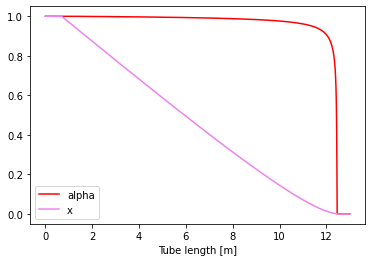

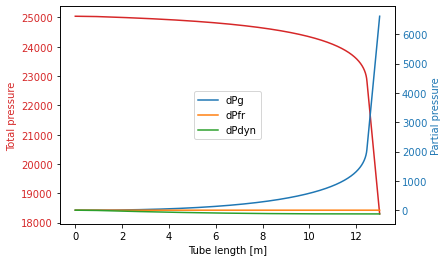

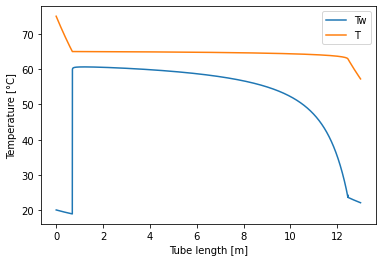

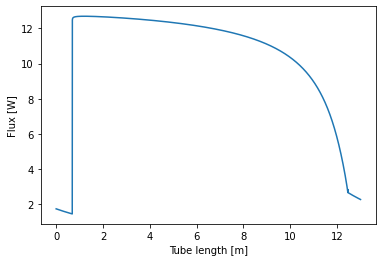

hv = [28.183840660328542,2639.232531322611] W/m2/K


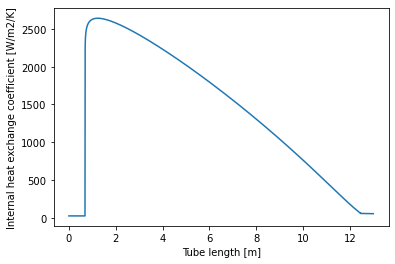

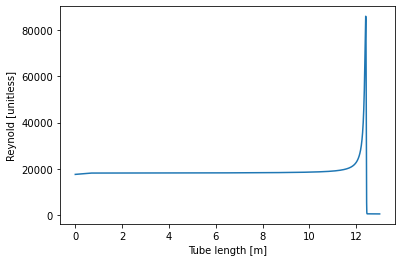

In [22]:
#Plot
Len = np.array(range(0,ni))*dx
plt.plot(Len,AL,'red',label='alpha')
plt.plot(Len,x,'violet',label='x')
plt.xlabel('Tube length [m]')
plt.legend()
#Plot the lines in and out the biphasic regim
# plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch)][0],color='gray',linestyle='--') #end of the superheating
# plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
#plt.savefig("title_fin.png",dpi=200)
plt.show()

# Pressure
fig, ax1 = plt.subplots()
ax1.set_xlabel('Tube length [m]')
ax1.set_ylabel('Total pressure', color='tab:red')
ax1.plot(Len, P, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
ax2.set_ylabel('Partial pressure', color='tab:blue') 
ax2.plot(Len,dPG, label = 'dPg')
ax2.plot(Len,dPfr,label = 'dPfr')
ax2.plot(Len,dPdyn,label = 'dPdyn')
ax2.tick_params(axis='y', labelcolor='tab:blue')
# plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch)][0],color='gray',linestyle='--') #end of the superheating
# plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
plt.legend(loc='center')
#plt.savefig("Pressure_fin.png",dpi=200)
plt.show()


plt.plot(Len[1:],(np.array(Tw)-273.15),label ='Tw')
plt.plot(Len,(np.array(T)-273.15), label = 'T')
plt.xlabel('Tube length [m]')
plt.ylabel('Temperature [°C]')
plt.legend()
# plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch)][0],color='gray',linestyle='--') #end of the superheating
# plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
#plt.savefig("Temperature_fin.png",dpi=200)
plt.show()

plt.plot(Len[1:],Q,label='Flux')
plt.xlabel('Tube length [m]')
plt.ylabel('Flux [W]')
# plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch)][0],color='gray',linestyle='--') #end of the superheating
# plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
#plt.savefig("Flux_fin.png",dpi=200)
plt.show()

plt.plot(Len[1:],hv,label = 'hv');print(f'hv = [{np.min(hv)},{np.max(hv)}] W/m2/K')
plt.xlabel('Tube length [m]')
plt.ylabel('Internal heat exchange coefficient [W/m2/K]')
# plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch)][0],color='gray',linestyle='--') #end of the superheating
# plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
#plt.savefig("hv_fin.png",dpi=200)
plt.show();

plt.plot(Len,Re,label = 'Reynold')
plt.xlabel('Tube length [m]')
plt.ylabel('Reynold [unitless]')
# plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch)][0],color='gray',linestyle='--') #end of the superheating
# plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
#plt.savefig("Reynold_fin.png",dpi=200)
plt.show();

## Variation analysis ( En cours)

For now, more the tube is inclined, later the condensation happen. Is it because the mass accumulation is not depedant of theta in the void rate function?

In [75]:
#Depdence with theta
Theta = np.linspace(0,np.pi/2,50)
Tw_thet, P_thet, x_thet = [],[],[]
for i,thet in enumerate(Theta):
    _,Twt,Pt,xt,_,_,_,_,_,_,_,_ = Model(theta = thet)
    Tw_thet.append(Twt)
    P_thet.append(Pt)
    x_thet.append(xt)
    if i%10==0:
        print(i)
#print("Phase 1 achieved")

0


C:\Users\Jolan\AppData\Local\Temp/ipykernel_9584/771028638.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  T.append(CP.PropsSI('T','P',P[-1],'Hmass',H[-1],'water'))
C:\Users\Jolan\AppData\Local\Temp/ipykernel_9584/771028638.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
  ro_gaz = min(CP.PropsSI('D','P',P[-1],'Q',1,'water'),CP.PropsSI('D','H',H[-1],'P',P[-1],'water')) #density pur gas
C:\Users\Jolan\AppData\Local\Temp/ipykernel_9584/771028638.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  return v*L/CP.PropsSI('V','P',p,'H',H,'water')
C:\Users\Jolan\AppData\Local\Temp/ipykernel_9584/771028638.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  Numono = 0.023*Reyn(G,Dh,P,H=H)**0.8*CP.PropsSI('Prandtl','P',P,'H',H,'water')**0.3
C:\Users\Jolan\AppData\Local\Temp/ipykernel_9584/2275284570.py:11: ComplexWarning: Casting complex values to real discards th

10
20
30
40


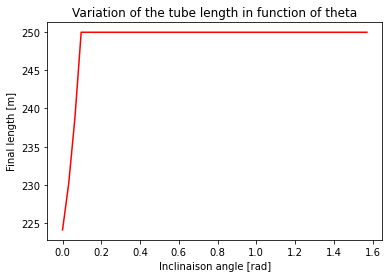

C:\Users\Jolan\miniconda3\envs\py39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


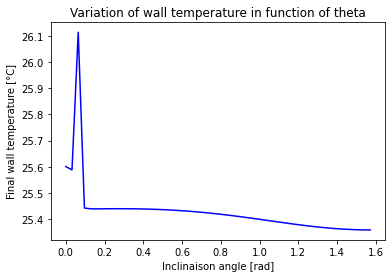

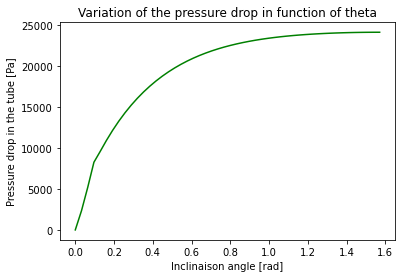

In [76]:
#Data for theta
indice = []
for i in x_thet:
    if np.min(i)<1e-7: #if the length Lmax is enough to evaporate the gas
        indice.append(np.where(np.array(i)<1e-7)[0][0])
    else:
        indice.append(-1)
Length = [Len[i] for i in indice] #Length at which there is only liquid
T_wall = [TW[i]-273.15 for (TW,i) in zip(Tw_thet,indice)] #wall temperature at the end
P_theta = [Pin - PF[i] for (PF,i) in zip(P_thet,indice)] #total pressure drop

#Plot
plt.plot(Theta,Length, 'red')
plt.ylabel('Final length [m]')
plt.xlabel('Inclinaison angle [rad]')
plt.title('Variation of the tube length in function of theta')
plt.show();
plt.plot(Theta,T_wall,'blue')
plt.ylabel('Final wall temperature [°C]')
plt.xlabel('Inclinaison angle [rad]')
plt.title('Variation of wall temperature in function of theta')
plt.show();
plt.plot(Theta,P_theta,'green')
plt.ylabel('Pressure drop in the tube [Pa]')
plt.xlabel('Inclinaison angle [rad]')
plt.title('Variation of the pressure drop in function of theta');

# END of the relevant part

## Attempt at optimise the code

In [103]:
#Model opti
def ModelOpt(mwater=mwater,Pin=Pin,Hin=Hin,Tin=Tin,theta=theta,Tamb = Tamb,hair=hair,
          Lmax=Lmax,et=et,w=w,dx=dx):
    #Init
    G ,Dh = mwater/(w*et), 4*w*et/(2*(w+et))
    Phys = np.ones((11,ni)) #Build the array that contains all the physical quantities
    hv0 = h_vapor(Pin,Hin,1,G,Dh)
    Q0,Tw0 = QandTw(Tin,e/condt/(dx*2*(w+et))+1/hv0/(dx*2*(w+et)))
    Init = [Pin,Hin,Tin,Tw0,0,0,0,hv0,1,1,Q0] #P,H,T,Tw,dPG,dPdyn,dPfr,hv,x,AL,Flux
    for p in range(np.shape(Phys)[0]):
        Phys[p][0] = Init[p]
    #Start the loop
    for i in range(1,ni): # loop for each mesh
        #Deduce the delta enthalpy
        dH = Phys[10][i-1]/mwater
        Phys[1][i] = Phys[1][i-1] - dH
        #Deduce the vapour title
        Phys[8][i] = Title(Phys[0][i-1],Phys[1][i])
        #Deduce Temperatures
        Phys[2][i] = CP.PropsSI('T','P',Phys[0][i-1],'H',Phys[1][i],'water')
        #Pressure losses du to friction
        ro_gaz = min(CP.PropsSI('D','P',Phys[0][i-1],'Q',1,'water'),CP.PropsSI('D','H',Phys[1][i],'P',Phys[0][i-1],'water')) #density pur gas
        ro_liq = CP.PropsSI('D','P',Phys[0][i-1],'Q',0,'water')
        A = zeta(Reyn(G,Dh,Phys[0][i-1],ph=0))*mwater**2/2/ro_liq/Dh
        #A = zeta(Reyn(G,Dh,Phys[0][i-1],ph=0))*G**2/2/ro_liq/Dh #Leviathan
        B = zeta(Reyn(G,Dh,Phys[0][i-1],ph=1))*mwater**2/2/ro_gaz/Dh
        #B = zeta(Reyn(G,Dh,Phys[0][i-1],ph=1))*G**2/2/ro_gaz/Dh #Leviathan
        Ge = A+2*(B-A)*Phys[8][i]
        dP = dx*(Ge*(1-Phys[8][i])**(1/3)+B*Phys[8][i]**3)
        Phys[6][i] =  Phys[6][i-1] + dP
        #Dynamical pressure losses
            #downstream cell
        Phys[9][i] = alpha(Phys[8][i],ro_gaz,ro_liq) #Void rate
        Pdyn1 = G**2*Phys[8][i]**2/ro_gaz/max(1e-7,Phys[9][i]) + G**2*(1-Phys[8][i])**2/ro_liq/(1-min((1-1e-7),Phys[9][i]))
        #Pdyn1 = G**2*Phys[8][i]**2/ro_gaz/max(1e-7,Phys[9][i])+G**2*(1-Phys[8][i])**2/ro_liq/max(1e-7,Phys[9][i]) #Leviathan
            #upstream cell
        indice = max(i-1,0) #at the begening P does not have 2 elements
        ro_gaz0 = min(CP.PropsSI('D','P',Phys[0][indice],'Q',1,'water'),CP.PropsSI('D','H',Phys[1][i-1],'P',Phys[0][indice],'water'))
        Pdyn0 = G**2*Phys[8][i-1]**2/ro_gaz0/max(1e-7,Phys[9][i-1]) + G**2*(1-Phys[8][i-1])**2/ro_liq/(1-min((1-1e-7),Phys[9][i-1]))
        #Pdyn0 = G**2*Phys[9][i-1]**2/ro_gaz0/max(1e-7,Phys[10][i-1]) + G**2*(1-Phys[9][i-1])**2/ro_liq/max(1e-7,Phys[10][i-1]) #Leviathan
        Phys[5][i] = Phys[5][i-1] + Pdyn1-Pdyn0
        #Gravitational pressure losses
        dPg = dx*((1-Phys[9][i])*ro_liq+Phys[9][i]*ro_gaz)*9.81*np.sin(theta)
        Phys[4][i] = Phys[4][i-1] + dPg
        Phys[0][i] = Phys[0][i-1] - (dP + dPg - Pdyn1-Pdyn0)
        #internal exchange coefficient calculation
        Phys[7][i] =  h_vapor(Phys[0][i],Phys[1][i],Phys[8][i],G,Dh)
        #Calculation of the flux and wall temperature
        Req = e/condt/(dx*2*(w+et))+1/Phys[7][i]/(dx*2*(w+et))
        Phys[10][i],Phys[3][i] = QandTw(Phys[2][i],Req)
    return Phys #P,H,T,Tw,dPG,dPdyn,dPfr,hv,hnet,x,AL,Flux

import time

t = time.process_time()
Datas = ModelOpt()
elapsed_time1 = time.process_time() - t
t = time.process_time()
T,Tw,P,x,AL,hv,dPfr,dPdyn,dPG, Q, H = Model()
elapsed_time2 = time.process_time() - t

print(elapsed_time1,elapsed_time2)

16.375 17.84375


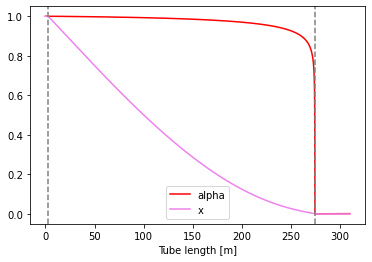

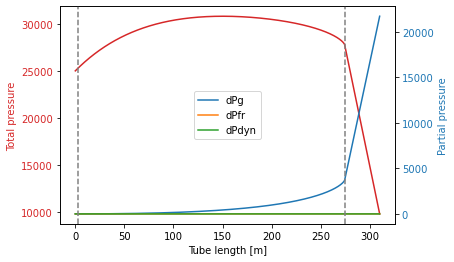

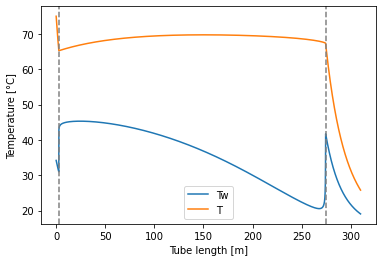

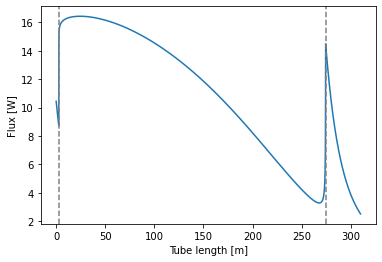

hv = [1.395003381240312,15.715633260995133] W/m2/K


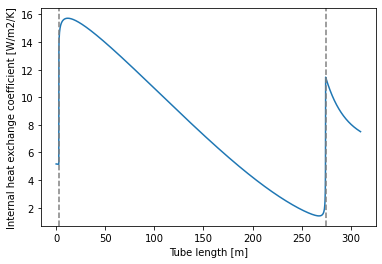

In [102]:
#Datas
P,H,T,Tw,dPG,dPdyn,dPfr,hv,x,AL,Q = Datas[0],Datas[1],Datas[2],Datas[3],Datas[4],Datas[5],Datas[6],Datas[7],Datas[8],Datas[9],Datas[10]
#Plot
Len = np.array(range(0,ni))*dx
plt.plot(Len,AL,'red',label='alpha')
plt.plot(Len,x,'violet',label='x')
plt.xlabel('Tube length [m]')
#Plot the lines in and out the biphasic regim
plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch+5e-1)][0],color='gray',linestyle='--') #end of the superheating
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
plt.legend()
#plt.savefig("title.png",dpi=200)
plt.show()

# Pressure
fig, ax1 = plt.subplots()
ax1.set_xlabel('Tube length [m]')
ax1.set_ylabel('Total pressure', color='tab:red')
ax1.plot(Len, P, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
ax2.set_ylabel('Partial pressure', color='tab:blue') 
ax2.plot(Len,dPG, label = 'dPg')
ax2.plot(Len,dPfr,label = 'dPfr')
ax2.plot(Len,dPdyn,label = 'dPdyn')
ax2.tick_params(axis='y', labelcolor='tab:blue')
plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch+5e-1)][0],color='gray',linestyle='--') #end of the superheating
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
plt.legend(loc='center')
#plt.savefig("Pressure.png",dpi=200)
plt.show()


plt.plot(Len,(np.array(Tw)-273.15),label ='Tw')
plt.plot(Len,(np.array(T)-273.15), label = 'T')
plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch+5e-1)][0],color='gray',linestyle='--') #end of the superheating
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
plt.xlabel('Tube length [m]')
plt.ylabel('Temperature [°C]')
plt.legend()
#plt.savefig("Temperature.png",dpi=200)
plt.show()

plt.plot(Len,Q,label='Flux')
plt.xlabel('Tube length [m]')
plt.ylabel('Flux [W]')
plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch+5e-1)][0],color='gray',linestyle='--') #end of the superheating
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
#plt.savefig("Flux.png",dpi=200)
plt.show()

plt.plot(Len,hv,label = 'hv');print(f'hv = [{np.min(hv)},{np.max(hv)}] W/m2/K')
plt.xlabel('Tube length [m]')
plt.ylabel('Internal heat exchange coefficient [W/m2/K]')
plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch+5e-1)][0],color='gray',linestyle='--') #end of the superheating
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--'); #begening of the subcooling
#plt.savefig("hv.png",dpi=200)

Not much of a difference for now

**Test boucle QandTw**

9.929974544588168 33.23891033799282


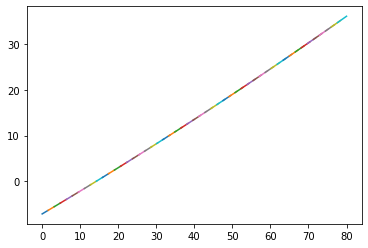

In [6]:
S=2*dx*(w+et)
Satm=w*dx
Ssun=w*dx
T = 338.14134857476466
Req = 3.197635411268698
for idx in range(N):
    y = np.array(Y[Cut[idx]:Cut[idx+1]+idx])*S-Qatm*Satm-Qsun*Ssun
    Q = (Coeff[idx][0]*T*S+Coeff[idx][1]*S-Qsun*Ssun-Qatm*Satm)/(1+Req*Coeff[idx][0]*S)
    Tw = T-Req*Q
    TW = np.linspace(Tw-10,Tw+10,500)
    plt.plot(Tc[Cut[idx]:Cut[idx+1]+idx],y)
    #print(y[0],Q,y[-1])
    if y[0]<=Q and y[-1]>=Q: #Check if the Q corresponds to the correct coefficient a,b
        print(Q,Tw-273.15)

**Inverse function with a fourth polynomial approximation**

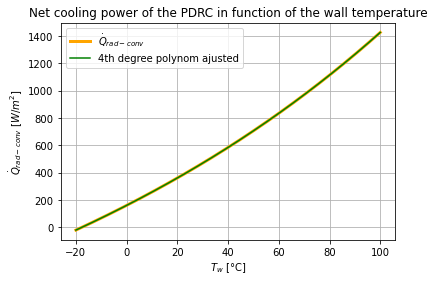

The maximum gap is 1.8189894035458565e-12 W/m^2


In [184]:
import numpy.polynomial.polynomial as nppol

x = np.linspace(-20,100,5000)
y = [Q_PDRC(T+273.15) for T in x]
#ajustement the polynom over a large scale
# coeff3 = np.polyfit(x,y,3)
# y3 = coeff3[0]*x**3 + coeff3[1]*x**2 + coeff3[2]*x + coeff3[3]
coeff4 = np.polyfit(x,y,4)
y4 = coeff4[0]*x**4+coeff4[1]*x**3 + coeff4[2]*x**2 + coeff4[3]*x + coeff4[4]

def Qadjust(x):
    y = coeff4[0]*x**4+coeff4[1]*x**3 + coeff4[2]*x**2 + coeff4[3]*x + coeff4[4]
    return y

def diff(x,a):
    yt = Qadjust(x)
    return (yt - a )**2

def Twc(Q):
    #Inverse function of Q_adjust working for every Q
    n = 100
    x = np.arange(Q*(1-0.2), Q*(1+0.2), 2*Q*0.2/n)
    y = np.zeros(x.shape)
    for idx,x_value in enumerate(x):
        res = minimize(diff, 1.0, args=(x_value), method='Nelder-Mead', tol=1e-6)
        y[idx] = res.x[0]
    return y[int(n/2)]+273.15

def TwcQuick(Tmin,Tmax):
    #Plot the inverse function of Q valid within T =[Tmin;Tmax] °C
    Q = [Q_PDRC(T+273.15) for T in np.linspace(Tmin,Tmax,100)]
    x = np.arange(np.min(Q),np.max(Q),1e-2)
    y = np.zeros(x.shape)
    for idx,x_value in enumerate(x):
        res = minimize(diff, 1.0, args=(x_value), method='Nelder-Mead', tol=1e-6)
        y[idx] = res.x[0]
    return x,y

#Plot
plt.plot(x,y,'orange', label='$\dot{Q}_{rad-conv}$',linewidth = 3)
#plt.plot(x,y2,'red',label = '2nd degree')
plt.plot(x,y4,'green',label = '4th degree polynom ajusted')
plt.xlabel('$T_w$ [°C]')
plt.ylabel('$\dot{Q}_{rad-conv} \ [W/m^2]$')
plt.title('Net cooling power of the PDRC in function of the wall temperature')
plt.legend()
plt.grid()
#plt.savefig("PDRC.png",dpi=200)
plt.show()
#Plot inverse function
# X,TW = TwcQuick(-50,150)
# plt.plot(X,TW)

#Precision
print(f'The maximum gap is {np.max(abs(y-y4))} W/m^2')

**Old Code**

In [ ]:
def Model2(mwater=mwater,Pin=Pin,Hin=Hin,Tin=Tin,theta=theta,Tamb = Tamb,hair=hair,
          Lmax=Lmax,et=et,w=w,dx=dx):
    #Init
    P,H,T,Tw,dPG,dPdyn,dPfr,hv,hrad,x,AL,Flux = [Pin],[Hin],[Tin],[Tw0],[0],[0],[0],[],[hrad0],[1],[1],[Qrad0-Qsun-Qatm-Qair] #decompose the hnet
    G ,Dh, Sair = mwater/(w*et), 4*w*et/(2*(w+et)), 0
    for i in range(1,ni): # loop for each mesh
        #internal exchange coefficient calculation
        h = h_vapor(P[-1],H[-1],x[-1],G,Dh)
        hv.append(h)
        #Calculation of the flux
        Q = 1/(e/condt/Srad_dx+1/h/(dx*2*(w+et))+1/(hrad[-1]*Srad_dx-hsun*Ssun_dx-hatm*Satm_dx-hair*Sair_dx))*(T[-1]-Tamb) #decompose the hnet
        Flux.append(Q)
        #Deduce the delta enthalpy
        dH = Q/mwater
        H.append(H[-1]-dH)
        #Deduce the vapour title
        x.append(Title(P[-1],H[-1])) #must stay between 0 and 1
        #Deduce Temperatures
        T.append(CP.PropsSI('T','P',P[-1],'H',H[-1],'water'))
        Tw.append(TwcLin(Q))
        #Tw.append(Twc(Q))
        #external radiative exchange coefficient
        hrad.append(Q/(Tw[-1]-Tamb)/Srad_dx) #decompose hnet
        #Pressure losses du to friction
        ro_gaz = min(CP.PropsSI('D','P',P[-1],'Q',1,'water'),CP.PropsSI('D','H',H[-1],'P',P[-1],'water')) #Leviathan
        #ro_gaz = CP.PropsSI('D','H',H[-1],'P',P[-1],'water')
        ro_liq = CP.PropsSI('D','P',P[-1],'Q',0,'water')
        A = zeta(Reyn(G,Dh,P[-1],ph=0))*mwater**2/2/ro_liq/Dh
        #A = zeta(Reyn(G,Dh,P[-1],ph=0))*G**2/2/ro_liq/Dh #Leviathan
        B = zeta(Reyn(G,Dh,P[-1],ph=1))*mwater**2/2/ro_gaz/Dh
        #B = zeta(Reyn(G,Dh,P[-1],ph=1))*G**2/2/ro_gaz/Dh #Leviathan
        Ge = A+2*(B-A)*x[-1]
        dP = dx*(Ge*(1-x[-1])**(1/3)+B*x[-1]**3)
        #Dynamical pressure losses
            #downstream cell
        AL.append(alpha(x[-1],ro_gaz,ro_liq))
        Pdyn1 = G**2*x[-1]**2/ro_gaz/max(1e-7,AL[-1]) + G**2*(1-x[-1])**2/ro_liq/(1-min((1-1e-7),AL[-1])) #max(1e-7,AL[-1])
        #Pdyn1 = G**2*x[-1]**2/ro_gaz/max(1e-7,AL[-1])+G**2*(1-x[-1])**2/ro_liq/max(1e-7,AL[-1]) #Leviathan
            #upstream cell
        indice = max(i-1,0) #at the begening P does not have 2 elements
        ro_gaz0 = min(CP.PropsSI('D','P',P[indice],'Q',1,'water'),CP.PropsSI('D','H',H[-2],'P',P[indice],'water')) #Leviathan
        #ro_gaz0 = CP.PropsSI('D','H',H[-2],'P',P[indice],'water')
        Pdyn0 = G**2*x[-2]**2/ro_gaz0/max(1e-7,AL[-2]) + G**2*(1-x[-2])**2/ro_liq/(1-min((1-1e-7),AL[-2]))
        #Pdyn0 = G**2*x[-2]**2/ro_gaz0/max(1e-7,AL[-2]) + G**2*(1-x[-2])**2/ro_liq/max(1-1e-7,AL[-2]) #Leviathan
        #Gravitational pressure losses
        dPg = dx*((1-AL[-1])*ro_liq+AL[-1]*ro_gaz)*9.81*np.sin(theta)
        dPG.append(dPg)
        dPdyn.append(Pdyn1-Pdyn0) #;print(Pdyn0-Pdyn1)
        dPfr.append(dP) #;print(dP)
        P.append(P[-1]-(dPfr[-1]+dPG[-1]-dPdyn[-1]))
        #Fin's surface
        Sair+=Sair_dx
    return T,Tw,P,x,AL,hv,hnet,dPfr,dPdyn,dPG, Flux,Sair
